# PAMAP2
- 피험자 별로 데이터를 split
- 성능 평가 지표를 val_sparse_categorical_accuracy에서 val_loss로 변경
- early stopping의 patience를 15에서 25로 늘림
- 심각한 성능 저하...! 피험자별로 데이터를 split한 것의 영향

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv1D, MaxPool1D, BatchNormalization, Dense,
                                     Input, ReLU, Dropout, LayerNormalization,
                                     MultiHeadAttention, GlobalAveragePooling1D, GRU)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/AI_data/PAMAP2/PAMAP2_integrated_data.csv')

In [ ]:
df.head()

,timestamp,activityID,heart_rate,hand_temp,hand_acc_16g_x,hand_acc_16g_y,hand_acc_16g_z,hand_acc_6g_x,hand_acc_6g_y,hand_acc_6g_z,...,ankle_gyro_y,ankle_gyro_z,ankle_mag_x,ankle_mag_y,ankle_mag_z,ankle_orient_1,ankle_orient_2,ankle_orient_3,ankle_orient_4,subject
0,8.38,0.0,104.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.0,0.0,0.0,0.0,Protocol_subject101
1,8.39,0.0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0,Protocol_subject101
2,8.40,0.0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0,Protocol_subject101
3,8.41,0.0,NaN,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.0,0.0,0.0,0.0,Protocol_subject101
4,8.42,0.0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.0,0.0,0.0,0.0,Protocol_subject101


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3850505 entries, 0 to 3850504
Data columns (total 55 columns):
 #   Column           Dtype  
---  ------           -----  
 0   timestamp        float64
 1   activityID       float64
 2   heart_rate       float64
 3   hand_temp        float64
 4   hand_acc_16g_x   float64
 5   hand_acc_16g_y   float64
 6   hand_acc_16g_z   float64
 7   hand_acc_6g_x    float64
 8   hand_acc_6g_y    float64
 9   hand_acc_6g_z    float64
 10  hand_gyro_x      float64
 11  hand_gyro_y      float64
 12  hand_gyro_z      float64
 13  hand_mag_x       float64
 14  hand_mag_y       float64
 15  hand_mag_z       float64
 16  hand_orient_1    float64
 17  hand_orient_2    float64
 18  hand_orient_3    float64
 19  hand_orient_4    float64
 20  chest_temp       float64
 21  chest_acc_16g_x  float64
 22  chest_acc_16g_y  float64
 23  chest_acc_16g_z  float64
 24  chest_acc_6g_x   float64
 25  chest_acc_6g_y   float64
 26  chest_acc_6g_z   float64
 27  chest_gyro_x

In [ ]:
df = df.drop(columns=['timestamp', 'heart_rate', 'hand_temp', 'hand_acc_6g_x', 'hand_acc_6g_y', 'hand_acc_6g_z', 'hand_orient_1', 'hand_orient_2', 'hand_orient_3', 'hand_orient_4',
                 'chest_temp', 'chest_acc_6g_x', 'chest_acc_6g_y', 'chest_acc_6g_z', 'chest_orient_1', 'chest_orient_2', 'chest_orient_3', 'chest_orient_4', 'ankle_temp', 'ankle_acc_6g_x', 'ankle_acc_6g_y', 'ankle_acc_6g_z',
                 'ankle_orient_1', 'ankle_orient_2', 'ankle_orient_3', 'ankle_orient_4'])

In [ ]:
df.isna().sum()

,0
activityID,0
hand_acc_16g_x,14338
hand_acc_16g_y,14338
hand_acc_16g_z,14338
hand_gyro_x,14338
hand_gyro_y,14338
hand_gyro_z,14338
hand_mag_x,14338
hand_mag_y,14338
hand_mag_z,14338


활동(activity)별 데이터프레임 구성 및 NaN 처리
- activityID 0을 제외하고 필요한 활동(집안일 등 생활잡음을 제외한 12개)만 사용
- 활동 별로 fill와 bill을 이용해서 결측값을 처리 -> 활동의 고유한 패턴이 왜곡되지 않도록

In [ ]:
activity_mapping = {
        1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6,
        12: 7, 13: 8, 16: 9, 17: 10, 24: 11
    }
df = df[df["activityID"].isin(activity_mapping.keys())]

# 각 활동(activity)별로 DataFrame을 구성하고, bfill과 ffill을 적용하여 NaN 처리
df_list = []
for activity_id in df['activityID'].unique():
    activity_df = df[df['activityID'] == activity_id].copy()
    # ffill과 bfill을 순차적으로 적용하여 결측치 채우기
    activity_df = activity_df.fillna(method='ffill').fillna(method='bfill')
    # 또는 선형 보간 사용 (linear interpolation)
    # activity_df = activity_df.interpolate(method='linear')
    df_list.append(activity_df)

# 처리된 DataFrame들을 다시 하나로 합치기
df_processed = pd.concat(df_list, ignore_index=True)
df_processed.head()

/tmp/ipython-input-2476589672.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  activity_df = activity_df.fillna(method='ffill').fillna(method='bfill')


,activityID,hand_acc_16g_x,hand_acc_16g_y,hand_acc_16g_z,hand_gyro_x,hand_gyro_y,hand_gyro_z,hand_mag_x,hand_mag_y,hand_mag_z,...,ankle_acc_16g_x,ankle_acc_16g_y,ankle_acc_16g_z,ankle_gyro_x,ankle_gyro_y,ankle_gyro_z,ankle_mag_x,ankle_mag_y,ankle_mag_z,subject
0,1.0,2.21530,8.27915,5.58753,-0.004750,0.037579,-0.011145,8.93200,-67.9326,-19.9755,...,9.73855,-1.84761,0.095156,0.002908,-0.027714,0.001752,-61.1081,-36.8636,-58.3696,Protocol_subject101
1,1.0,2.29196,7.67288,5.74467,-0.171710,0.025479,-0.009538,9.58300,-67.9584,-20.9091,...,9.69762,-1.88438,-0.020804,0.020882,0.000945,0.006007,-60.8916,-36.3197,-58.3656,Protocol_subject101
2,1.0,2.29090,7.14240,5.82342,-0.238241,0.011214,0.000831,9.05516,-67.4017,-19.5083,...,9.69633,-1.92203,-0.059173,-0.035392,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119,Protocol_subject101
3,1.0,2.21800,7.14365,5.89930,-0.192912,0.019053,0.013374,9.92698,-67.4387,-20.5602,...,9.66370,-1.84714,0.094385,-0.032514,-0.018844,0.026950,-60.7646,-37.1028,-57.8799,Protocol_subject101
4,1.0,2.30106,7.25857,6.09259,-0.069961,-0.018328,0.004582,9.15626,-67.1825,-20.0857,...,9.77578,-1.88582,0.095775,0.001351,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847,Protocol_subject101


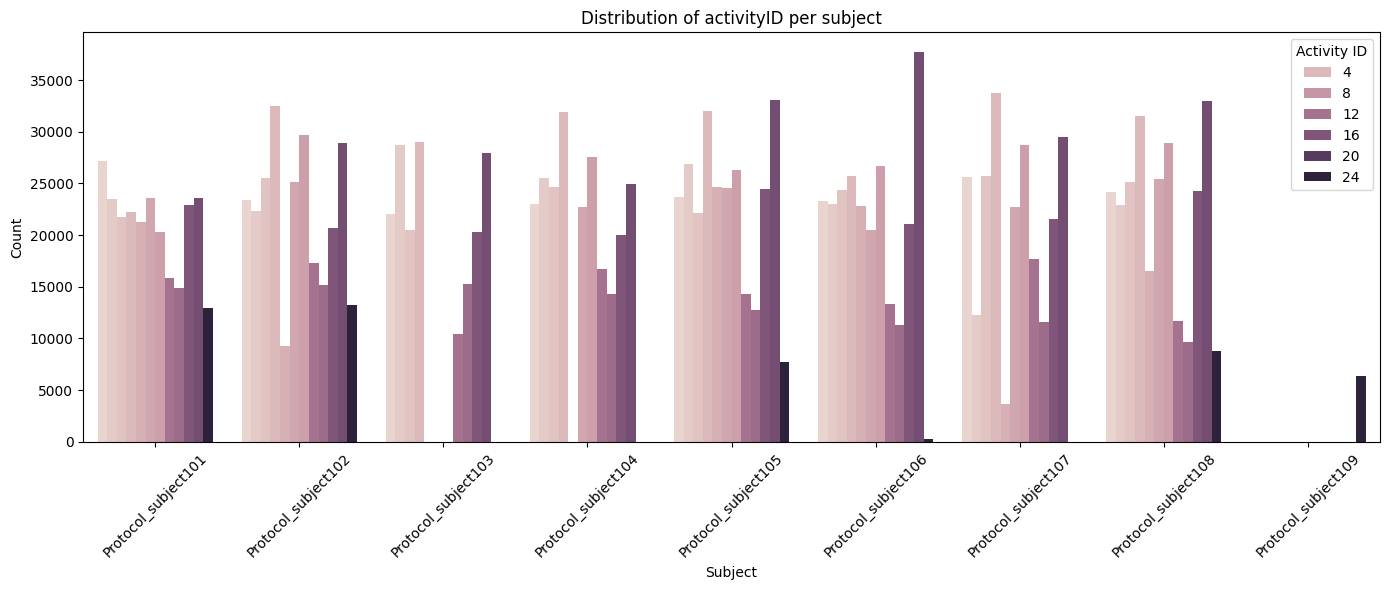

In [ ]:
counts = df_processed.groupby(['subject', 'activityID']).size().reset_index(name='count')

plt.figure(figsize=(14, 6))
sns.barplot(
    data=counts,
    x='subject',
    y='count',
    hue='activityID'
)

plt.title('Distribution of activityID per subject')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.legend(title='Activity ID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
scaler = MinMaxScaler()
features_to_scale = df_processed.columns.drop(['subject', 'activityID'])
df_processed[features_to_scale] = scaler.fit_transform(df_processed[features_to_scale])

In [ ]:
TIME_STEPS = 100 # 1 sec (100Hz sampling)
STEPS = 50       # 50% overlap

def create_dataset(X, y, time_steps, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        x = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(x)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [ ]:
train_df = df_processed[~df_processed['subject'].isin(['Protocol_subject101', 'Protocol_subject102'])]
val_df = df_processed[df_processed['subject'] == 'Protocol_subject101']
test_df = df_processed[df_processed['subject'] == 'Protocol_subject102']

In [ ]:
def prepare_data_split(df):
    X = df.drop(columns=['activityID', 'subject'])
    y = df['activityID'].map(activity_mapping)
    X_seq, y_seq = create_dataset(X, y, TIME_STEPS, STEPS)
    return X_seq, y_seq.flatten()

In [ ]:
X_train, y_train = prepare_data_split(train_df)
X_val, y_val = prepare_data_split(val_df)
X_test, y_test = prepare_data_split(test_df)

print(f"\nSubject-based data split:")
print(f"Train set size: X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}")
print(f"Validation set size: X_val.shape = {X_val.shape}, y_val.shape = {y_val.shape}")
print(f"Test set size: X_test.shape = {X_test.shape}, y_test.shape = {y_test.shape}")


Subject-based data split:
Train set size: X_train.shape = (28590, 100, 27), y_train.shape = (28590,)
Validation set size: X_val.shape = (4998, 100, 27), y_val.shape = (4998,)
Test set size: X_test.shape = (5265, 100, 27), y_test.shape = (5265,)


In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = len(np.unique(y_train))

model = Sequential([
        Conv1D(64, 5, activation='relu', input_shape=input_shape),
        BatchNormalization(),

        Conv1D(128, 3, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        MaxPool1D(2),

        Conv1D(256, 3, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        GRU(256, return_sequences=True, dropout=0.3),
        GRU(128, dropout=0.3),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 96, 64)         │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 96, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 94, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 94, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 94, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 47, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 45, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 45, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 45, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 45, 256)        │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 128)            │       148,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │           780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 686,028 (2.62 MB)

 Trainable params: 685,004 (2.61 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [ ]:
callbacks = [
            ModelCheckpoint(
                "PAMAP2_CNN_GRU_best.h5",
                save_best_only=True,
                monitor="val_loss",
                mode='min',
                verbose=1
            ),
            EarlyStopping(
                monitor="val_loss",
                patience=25,
                verbose=1,
                mode='min',
                restore_best_weights=True
            ),
            ReduceLROnPlateau(
                monitor='val_loss', # val_loss가 epoch 10 동안 개선되지 않으면
                factor=0.1, # 학습률을 0.1배로 줄임
                patience=10,
                min_lr=0.00001, # 학습률의 최솟값
                verbose=1)
        ]

In [ ]:
history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=64,
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

Epoch 1/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.0740 - sparse_categorical_accuracy: 0.6797
Epoch 1: val_loss improved from inf to 3.24964, saving model to PAMAP2_CNN_GRU_best.h5


447/447 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - loss: 1.0731 - sparse_categorical_accuracy: 0.6799 - val_loss: 3.2496 - val_sparse_categorical_accuracy: 0.2687 - learning_rate: 0.0010
Epoch 2/100
444/447 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3126 - sparse_categorical_accuracy: 0.9100
Epoch 2: val_loss did not improve from 3.24964
447/447 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.3124 - sparse_categorical_accuracy: 0.9101 - val_loss: 3.9100 - val_sparse_categorical_accuracy: 0.3471 - learning_rate: 0.0010
Epoch 3/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2260 - sparse_categorical_accuracy: 0.9332
Epoch 3: val_loss did not improve from 3.24964
447/447 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.2260 - sparse_categorical_accuracy: 0.9332 - val_loss: 3.3463 - val_sparse_categorical_accuracy: 0.3641 - learning_rate: 0.0010
Epoch 4/100
444/447 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1720 - sparse_categorical_accuracy: 0.9491
Epoch 4: val_loss improved from 3.24964 to 2

447/447 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.1720 - sparse_categorical_accuracy: 0.9491 - val_loss: 2.4415 - val_sparse_categorical_accuracy: 0.5546 - learning_rate: 0.0010
Epoch 5/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1538 - sparse_categorical_accuracy: 0.9544
Epoch 5: val_loss did not improve from 2.44146
447/447 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.1538 - sparse_categorical_accuracy: 0.9544 - val_loss: 3.2878 - val_sparse_categorical_accuracy: 0.5130 - learning_rate: 0.0010
Epoch 6/100
444/447 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1450 - sparse_categorical_accuracy: 0.9580
Epoch 6: val_loss did not improve from 2.44146
447/447 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - loss: 0.1450 - sparse_categorical_accuracy: 0.9580 - val_loss: 2.9645 - val_sparse_categorical_accuracy: 0.4254 - learning_rate: 0.0010
Epoch 7/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1191 - sparse_categorical_accuracy: 0.9644
Epoch 7: val_loss did not improve from 2.4

In [ ]:
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training accuracy: {train_acc * 100:.2f}%")
print(f"Training loss: {train_loss:.4f}")

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

Training accuracy: 69.85%
Training loss: 1.1719
Test accuracy: 49.17%
Test loss: 2.5560


macro avg
- precision, recall, f1-score를 단순 평균
- 데이터 불균형 고려 X
- 클래스 불균형이 심한 데이터셋에서 macro avg는 모델이 소수 클래스를 얼마나 잘 예측하는지 파악하는 데 유용

weighted avg
- precision, recalll, f1-score에 support(샘플의 수)값을 곱하여 가중 평균을 낸 값
- 데이터 양이 많은 다수 클래스의 성능이 전체 평균에 더 큰 영향을 미침
- weighted avg > macro avg일 경우, 모델이 다수 클래스에서는 좋은 성능을 보이지만 소수 클래스에서는 성능이 저조하다는 뜻

In [ ]:
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# 분류 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))


Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9252    0.9612       468
           1     0.0000    0.0000    0.0000       447
           2     0.0000    0.0000    0.0000       512
           3     0.8609    0.1521    0.2585       651
           4     0.6667    0.9405    0.7803       185
           5     0.9921    0.4980    0.6631       502
           6     0.6568    0.8249    0.7313       594
           7     0.4254    0.2795    0.3374       347
           8     0.5739    0.5362    0.5544       304
           9     0.1674    0.9952    0.2866       414
          10     0.9833    0.8163    0.8920       577
          11     0.0000    0.0000    0.0000       264

    accuracy                         0.4917      5265
   macro avg     0.5272    0.4973    0.4554      5265
weighted avg     0.5696    0.4917    0.4651      5265



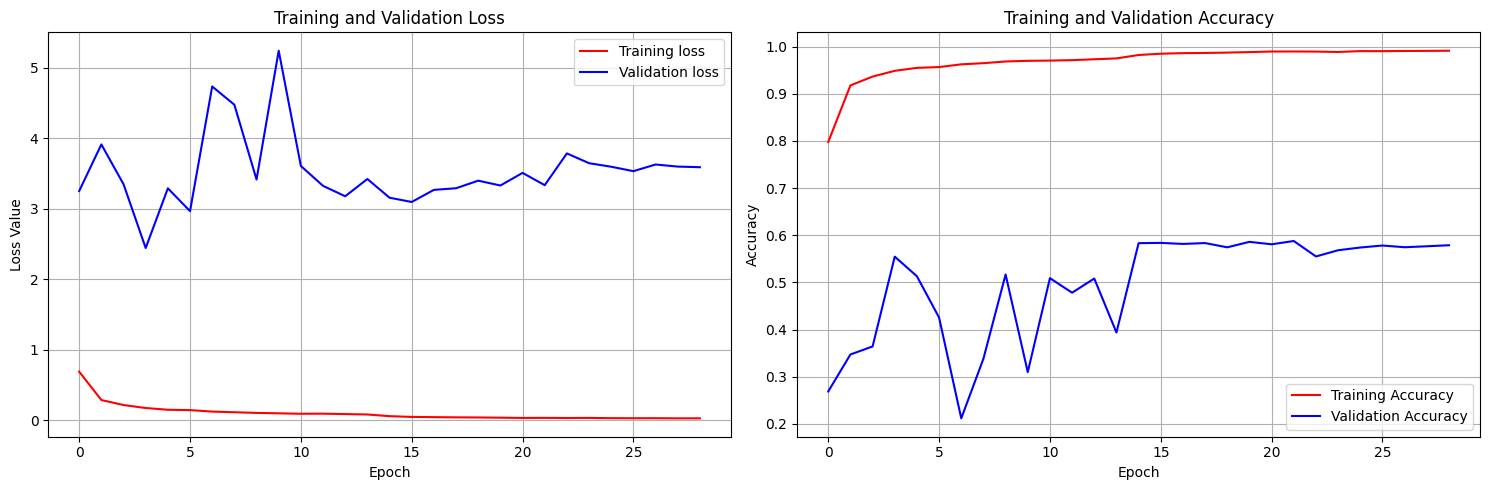

In [ ]:
train_loss = history.history['loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_sparse_categorical_accuracy']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, 'r', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, 'r', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

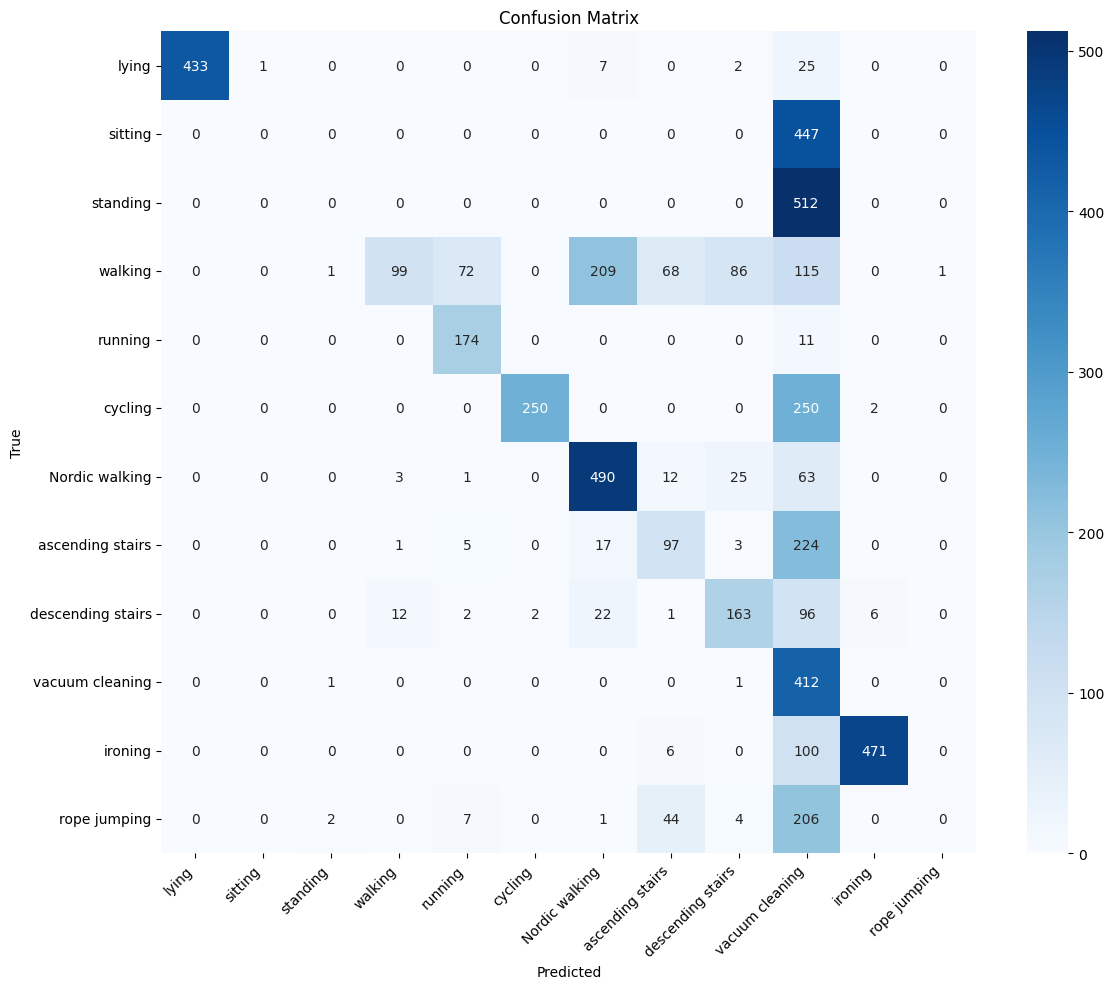

In [ ]:
LABELS = ['lying', 'sitting', 'standing', 'walking', 'running', 'cycling', 'Nordic walking', 'ascending stairs', 'descending stairs', 'vacuum cleaning', 'ironing', 'rope jumping']

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')


if num_classes <= len(LABELS):
    plt.gca().set_xticklabels(LABELS[:num_classes], rotation=45, ha='right')
    plt.gca().set_yticklabels(LABELS[:num_classes], rotation=0)

plt.tight_layout()
plt.show()